C:\Users\jmlgr\AppData\Local\Temp\ipykernel_30488\1857506598.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ym[i+1] = y1[-1]


Initial SSE Objective: 29.03914962021704


C:\Users\jmlgr\AppData\Local\Temp\ipykernel_30488\1857506598.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ym[i+1] = y1[-1]


Final SSE Objective: 0.2970486077536641
Kp: 3.014760950570703
taup: 1.860535260286978
thetap: 2.934730199778393


C:\Users\jmlgr\AppData\Local\Temp\ipykernel_30488\1857506598.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ym[i+1] = y1[-1]


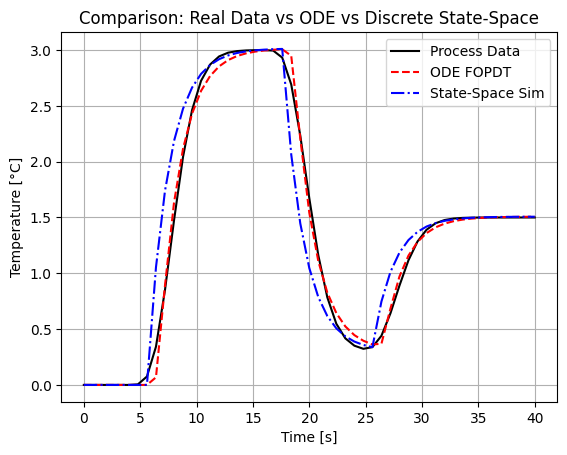

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# === Load Data ===
url = 'http://apmonitor.com/pdc/uploads/Main/data_fopdt.txt'
data = pd.read_csv(url)
t = data['time'].values - data['time'].values[0]
u = data['u'].values
yp = data['y'].values
u0 = u[0]
yp0 = yp[0]

# === Setup ===
ns = len(t)
delta_t = t[1] - t[0]
uf = interp1d(t, u)

# === FOPDT Model Function (for ODE integration) ===
def fopdt(y, t, uf, Km, taum, thetam):
    try:
        if (t - thetam) <= 0:
            um = uf(0.0)
        else:
            um = uf(t - thetam)
    except:
        um = u0
    dydt = (-(y - yp0) + Km * (um - u0)) / taum
    return dydt

# === Simulate FOPDT Model ===
def sim_model(x):
    Km, taum, thetam = x
    ym = np.zeros(ns)
    ym[0] = yp0
    for i in range(ns - 1):
        ts = [t[i], t[i+1]]
        y1 = odeint(fopdt, ym[i], ts, args=(uf, Km, taum, thetam))
        ym[i+1] = y1[-1]
    return ym

# === Objective Function ===
def objective(x):
    ym = sim_model(x)
    return np.sum((ym - yp) ** 2)

# === Fit Model ===
x0 = [2.0, 3.0, 0.0]  # initial guess
print('Initial SSE Objective:', objective(x0))
solution = minimize(objective, x0)
x = solution.x
print('Final SSE Objective:', objective(x))
print('Kp:', x[0])
print('taup:', x[1])
print('thetap:', x[2])

# === Simulate Discrete-Time State-Space Model ===
Kp, taup, thetap = x
A = np.exp(-delta_t / taup)
B = Kp * (1 - A)
d = int(thetap / delta_t)

u_hist = np.zeros(d + 1)
xd = np.zeros(ns)
yd = np.zeros(ns)
xd[0] = yp0

for k in range(1, ns):
    u_hist = np.roll(u_hist, -1)
    u_hist[-1] = u[k]
    xd[k] = A * xd[k - 1] + B * u_hist[0]
    yd[k] = xd[k]

# === Plot Results ===
plt.figure()
plt.plot(t, yp, 'k-', label='Process Data')
plt.plot(t, sim_model(x), 'r--', label='ODE FOPDT')
plt.plot(t, yd, 'b-.', label='State-Space Sim')
plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]')
plt.title('Comparison: Real Data vs ODE vs Discrete State-Space')
plt.legend()
plt.grid(True)
plt.show()


In [33]:
print(f"A: {A}")
print(f"B: {B}")

A: 0.6505196404866488
B: 1.0535997408522617


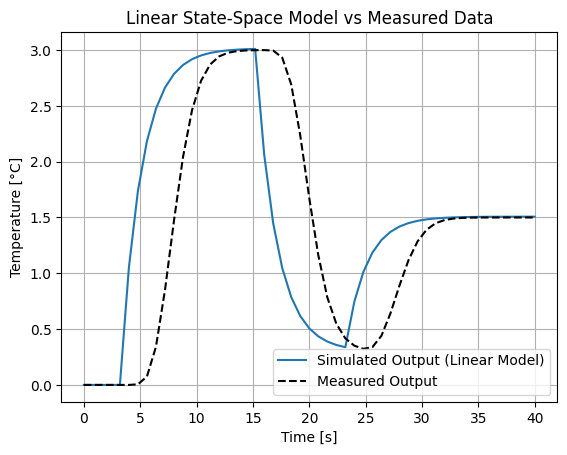

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Load Input Data ---
url = 'http://apmonitor.com/pdc/uploads/Main/data_fopdt.txt'
data = pd.read_csv(url)
t = data['time'].values - data['time'].values[0]
u = data['u'].values
delta_t = t[1] - t[0]
ns = len(t)

# --- System Model: dx = A*x + B*u ---
A = 0.6505196404866488
B = 1.0535997408522617

# --- Allocate and Simulate ---
x = np.zeros(ns)
y = np.zeros(ns)

for k in range(1, ns):
    x[k] = A * x[k - 1] + B * u[k]
    y[k] = x[k]

# --- Plot Result ---
plt.plot(t, y, label='Simulated Output (Linear Model)')
plt.plot(t, data['y'], 'k--', label='Measured Output')
plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]')
plt.title('Linear State-Space Model vs Measured Data')
plt.grid(True)
plt.legend()
plt.show()


A: 0.8705587884119067 B: 0.42319834605731194


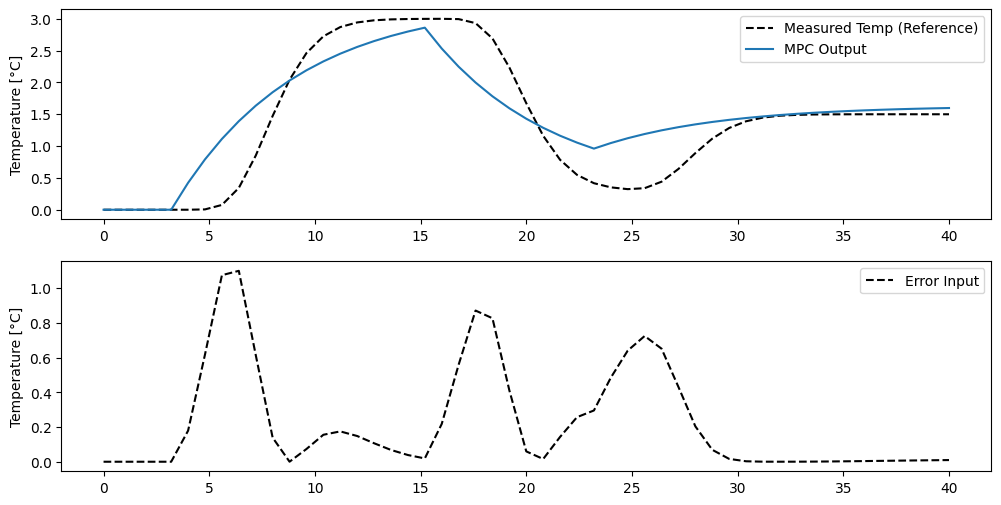

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# --- System Parameters ---
A0 = 0.6505196404866488
B0 = 1.0535997408522617

# --- Load Reference Trajectory ---
url = 'http://apmonitor.com/pdc/uploads/Main/data_fopdt.txt'
data = pd.read_csv(url)

t = data['time'].values - data['time'].values[0]
u_measured = data['u'].values
y_measured = data['y'].values
delta_t = t[1] - t[0]

sim_steps = len(t)
ref_traj = y_measured  # use output as reference

def mpc_cost(theta, r_seq, u_measured):
    A, B = theta
    cost = 0.0
    x = y_measured[0]
    for k, u in enumerate(u_measured):
        x = A * x + B * u
        cost += (x - r_seq[k]) ** 2
    return cost

def run_sim(r_seq, u_measured):
    theta0 = [A0, B0]
    res = minimize(mpc_cost, theta0, args=(r_seq, u_measured), method='SLSQP')
    return res.x

A, B = run_sim(y_measured, u_measured)
print(f"A: {A} B: {B}")
xs = []
x = y_measured[0]
for k in range(sim_steps):
    x = A * x + B * u_measured[k]

    xs.append(x)

# --- Plot Comparison ---
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, ref_traj, 'k--', label="Measured Temp (Reference)")
plt.plot(t, xs, label="MPC Output")
plt.ylabel("Temperature [°C]")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, (y_measured - xs)**2, 'k--', label="Error Input")
plt.ylabel("Temperature [°C]")
plt.legend()

plt.show()


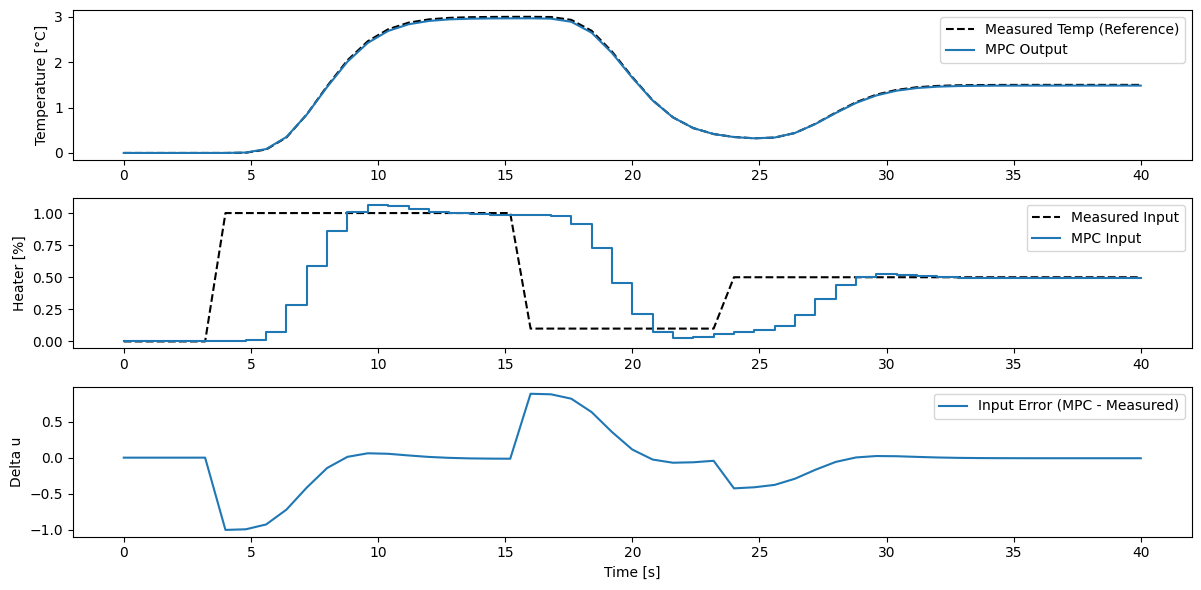

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# --- System Parameters ---
A = 0.6505196404866488
B = 1.0535997408522617

# --- MPC Settings ---
N = 10                     # horizon
lambda_u = 0.1             # input penalty
umin, umax = 0.0, 100.0    # input constraints

# --- Load Reference Trajectory ---
url = 'http://apmonitor.com/pdc/uploads/Main/data_fopdt.txt'
data = pd.read_csv(url)
t = data['time'].values - data['time'].values[0]
u_measured = data['u'].values
y_measured = data['y'].values
delta_t = t[1] - t[0]
sim_steps = len(t)
ref_traj = y_measured  # use output as reference

# --- Simulation ---
x = 0.0
xs = []
us = []

def mpc_cost(u_seq, x0, A, B, N, r_seq, lambda_u):
    cost = 0.0
    x = x0
    for i in range(N):
        u = u_seq[i]
        x = A * x + B * u
        cost += (x - r_seq[i]) ** 2 + lambda_u * u ** 2
    return cost

def run_mpc(x0, r_seq):
    u_init = np.zeros(N)
    bounds = [(umin, umax)] * N
    res = minimize(mpc_cost, u_init, args=(x0, A, B, N, r_seq, lambda_u), bounds=bounds, method='SLSQP')
    return res.x[0]

for k in range(sim_steps):
    # pad reference if we're near the end
    if k + N < len(ref_traj):
        r_seq = ref_traj[k:k+N]
    else:
        r_seq = list(ref_traj[k:]) + [ref_traj[-1]] * (N - (len(ref_traj) - k))

    u_k = run_mpc(x, r_seq)
    x = A * x + B * u_k

    xs.append(x)
    us.append(u_k)

# --- Plot Comparison ---
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(t, ref_traj, 'k--', label="Measured Temp (Reference)")
plt.plot(t, xs, label="MPC Output")
plt.ylabel("Temperature [°C]")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, u_measured, 'k--', label="Measured Input")
plt.step(t, us, where='post', label="MPC Input")
plt.ylabel("Heater [%]")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t, np.array(us) - u_measured, label="Input Error (MPC - Measured)")
plt.ylabel("Delta u")
plt.xlabel("Time [s]")
plt.legend()

plt.tight_layout()
plt.show()


In [37]:
import sympy as sp

# Symbols
x0, u0, u1, r, lambd = sp.symbols('x0 u0 u1 r lambda')
A_val = 0.65
B_val = 1.05

# Define future states
x1 = A_val * x0 + B_val * u0
x2 = A_val * x1 + B_val * u1

# Cost function
J = (x1 - r)**2 + (x2 - r)**2 + lambd * u0**2 + lambd * u1**2

# Compute gradients
dJ_du0 = sp.diff(J, u0)
dJ_du1 = sp.diff(J, u1)

# Solve for optimal inputs (unconstrained)
sol = sp.solve([dJ_du0, dJ_du1], (u0, u1), dict=True)[0]
u0_star = sol[u0].simplify()
u1_star = sol[u1].simplify()

# Display results
u0_star, u1_star


((277200.0*lambda*r - 155337.0*lambda*x0 + 185220.0*r - 120393.0*x0)/(160000.0*lambda**2 + 427329.0*lambda + 194481.0),
 (168000.0*lambda*r - 70980.0*lambda*x0 + 64827.0*r)/(160000.0*lambda**2 + 427329.0*lambda + 194481.0))

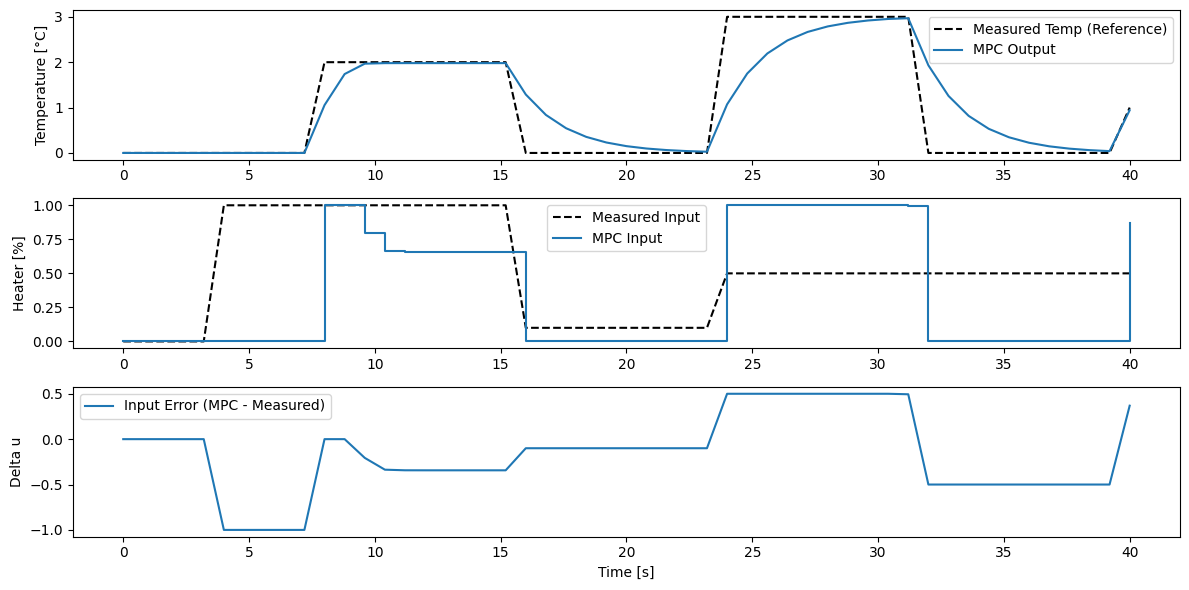

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# --- System Parameters ---
A = 0.6505196404866488
B = 1.0535997408522617

# --- MPC Settings ---
N = 10                     # horizon
lambda_u = 0.1             # input penalty
umin, umax = 0.0, 100.0    # input constraints

# --- Load Reference Trajectory ---
url = 'http://apmonitor.com/pdc/uploads/Main/data_fopdt.txt'
data = pd.read_csv(url)
t = data['time'].values - data['time'].values[0]
u_measured = data['u'].values
y_measured = data['y'].values
delta_t = t[1] - t[0]
sim_steps = len(t)
ref_traj = y_measured  # use output as reference
ref_traj = np.zeros(y_measured.size)
ref_traj[10:20] = 2
ref_traj[30:40] = 3
ref_traj[50:60] = 1
def run_mpc(x0, r):
    U0 = (277200.0*lambda_u*r - 155337.0*lambda_u*x0 + 185220.0*r - 120393.0*x0)/(160000.0*lambda_u**2 + 427329.0*lambda_u + 194481.0) 
    return max(0.0, min(1.0, U0))

# --- Simulation ---
x = 0.0
xs = []
us = []
for k in range(sim_steps):
    u_k = run_mpc(x, ref_traj[k])
    x = A * x + B * u_k

    xs.append(x)
    us.append(u_k)

# --- Plot Comparison ---
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(t, ref_traj, 'k--', label="Measured Temp (Reference)")
plt.plot(t, xs, label="MPC Output")
plt.ylabel("Temperature [°C]")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, u_measured, 'k--', label="Measured Input")
plt.step(t, us, where='post', label="MPC Input")
plt.ylabel("Heater [%]")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t, np.array(us) - u_measured, label="Input Error (MPC - Measured)")
plt.ylabel("Delta u")
plt.xlabel("Time [s]")
plt.legend()

plt.tight_layout()
plt.show()


In [39]:
import numpy as np
from scipy.optimize import minimize

# Define the MPC objective function again
def mpc_cost(u_seq, x0, A, B, N, r_seq, lambda_u):
    cost = 0.0
    x = x0
    for i in range(N):
        u = u_seq[i]
        x = A * x + B * u
        cost += (x - r_seq[i]) ** 2 + lambda_u * u ** 2
    return cost

def solve_mpc(x0, r, A, B, N=2, lambda_u=0.1):
    r_seq = [r] * N
    u_init = np.zeros(N)
    bounds = [(0, 100)] * N
    res = minimize(mpc_cost, u_init, args=(x0, A, B, N, r_seq, lambda_u), bounds=bounds, method='SLSQP')
    return res.x[0]

X_data = []
y_data = []

# Sample across range of x0 and r
x_vals = np.linspace(0, 5, 100)
r_vals = np.linspace(0, 5, 100)

for x0 in x_vals:
    for r in r_vals:
        u = solve_mpc(x0, r, A=0.65, B=1.05)
        X_data.append([x0, r])
        y_data.append(u)

X_data = np.array(X_data)
y_data = np.array(y_data)

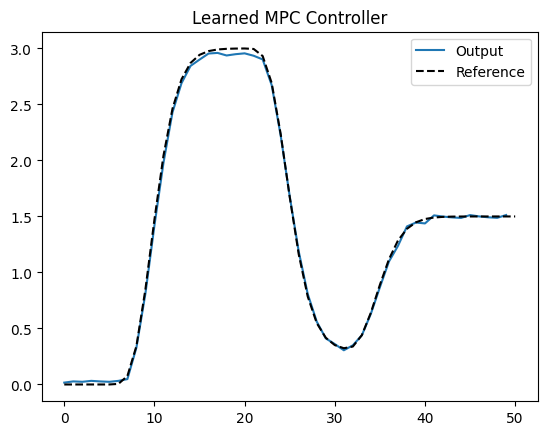

In [40]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100)
model.fit(X_data, y_data)

sim_steps = 50
r_seq = y_measured
x = 0
xs = []
us = []

for k in range(sim_steps):
    u_k = model.predict([[x, r_seq[k]]])[0]
    u_k = np.clip(u_k, 0, 100)  # safety clamp
    x = A * x + B * u_k
    xs.append(x)
    us.append(u_k)

import matplotlib.pyplot as plt
plt.plot(xs, label="Output")
plt.plot(r_seq, 'k--', label="Reference")
plt.legend()
plt.title("Learned MPC Controller")
plt.show()